
# Hematopoiesis scHopfield Analysis
==================================

This script replicates the analysis from the original Jupyter notebook using
the new scHopfield package API.

Analysis workflow:
1. Load and preprocess hematopoiesis data
2. Load CellOracle scaffold for network constraint
3. Fit gene regulatory network with scaffold
4. Compute energy landscapes
5. Correlation and network analyses
6. Jacobian stability analysis
7. Energy embedding and visualization
8. Gene perturbation simulations

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
from scipy.spatial.distance import squareform
import anndata
import dynamo as dyn
import celloracle as co

# Import the new scHopfield package
import scHopfield as sch


/home/bernaljp/envs/SCH/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Configuration

In [2]:
%matplotlib inline

In [3]:
# Data configuration
DATA_PATH = '/home/bernaljp/data/'  # Update this path
DATASET_NAME = 'Hematopoiesis'
DATASET_FILE = 'hematopoiesis.h5ad'  # Update filename

# Analysis parameters
CLUSTER_KEY = 'cell_type'  # Update to your cluster column name
VELOCITY_KEY = 'velocity_alpha_minus_gamma_s'
SPLICED_KEY = 'M_t'
DEGRADATION_KEY = 'gamma'
DYNAMIC_GENES_KEY = 'use_for_dynamics'

# Order for plotting (update with your cell types)
CELL_TYPE_ORDER = ['HSC', 'MEP-like', 'Ery', 'Meg', 'GMP-like', 'Mon', 'Neu', 'Bas']

# Network inference parameters
N_EPOCHS = 1000
BATCH_SIZE = 128
W_THRESHOLD = 1e-12
SCAFFOLD_REGULARIZATION = 1e-2
DEVICE = 'cuda'  # or 'cpu'

# Visualization parameters
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (10, 6)

## 1. Load and Preprocess Data

In [6]:
print("\n1. Loading data...")
adata = dyn.read_h5ad(DATA_PATH + DATASET_FILE)
print(f"   Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# Remove genes with NaN velocities (Hematopoiesis-specific)
if DATASET_NAME == 'Hematopoiesis':
    print("   Removing genes with NaN velocities...")
    bad_genes = np.unique(np.where(np.isnan(adata.layers[VELOCITY_KEY].toarray()))[1])
    adata = adata[:, ~np.isin(range(adata.n_vars), bad_genes)]
    print(f"   After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Get genes to use for analysis
genes_to_use = adata.var[DYNAMIC_GENES_KEY].values
n_genes = genes_to_use.sum()
print(f"   Using {n_genes} dynamic genes for analysis")


1. Loading data...
   Loaded: 1947 cells × 1956 genes
   Removing genes with NaN velocities...
   After filtering: 1947 cells × 1728 genes
   Using 1728 dynamic genes for analysis


## 2. Load Scaffold from CellOracle

In [7]:
print("\n2. Loading CellOracle scaffold...")
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

# Create scaffold matrix
scaffold = pd.DataFrame(
    0,
    index=adata.var.index[genes_to_use],
    columns=adata.var.index[genes_to_use]
)

# Convert gene names to lowercase for case-insensitive comparison
tfs = list(set(base_GRN.columns.str.lower()) & set(scaffold.index.str.lower()))
target_genes = list(set(base_GRN['gene_short_name'].str.lower().values) & set(scaffold.columns.str.lower()))

# Map original names for assignment
index_map = {gene.lower(): gene for gene in scaffold.index}
col_map = {gene.lower(): gene for gene in scaffold.columns}

# Fill scaffold with 1s where connections exist
for tf in tfs:
    tf_original = index_map[tf]
    tf_base_GRN = [col for col in base_GRN.columns if col.lower() == tf][0]

    for target in base_GRN[base_GRN[tf_base_GRN] == 1]['gene_short_name']:
        if target.lower() in target_genes:
            target_original = col_map[target.lower()]
            scaffold.loc[tf_original, target_original] = 1

print(f"   Scaffold created: {scaffold.sum().sum()} potential connections")
print(f"   TFs: {len(tfs)}, Target genes: {len(target_genes)}")


2. Loading CellOracle scaffold...
   Scaffold created: 41693 potential connections
   TFs: 73, Target genes: 1148


## 3. Fit Gene Regulatory Network

In [8]:
print("\n3. Fitting gene regulatory network with scHopfield...")

# Step 3a: Fit sigmoid functions
print("   3a. Fitting sigmoid functions...")
sch.pp.fit_all_sigmoids(
    adata,
    genes=genes_to_use,
    spliced_key=SPLICED_KEY,
    min_th=0.05
)
sch.pp.compute_sigmoid(adata, spliced_key=SPLICED_KEY)
print("   ✓ Sigmoid fitting complete")


3. Fitting gene regulatory network with scHopfield...
   3a. Fitting sigmoid functions...


/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


   ✓ Sigmoid fitting complete


In [9]:
# Step 3b: Infer interaction matrices
print("   3b. Inferring interaction matrices...")
sch.inf.fit_interactions(
    adata,
    cluster_key=CLUSTER_KEY,
    spliced_key=SPLICED_KEY,
    velocity_key=VELOCITY_KEY,
    degradation_key=DEGRADATION_KEY,
    w_threshold=W_THRESHOLD,
    w_scaffold=scaffold.values,
    scaffold_regularization=SCAFFOLD_REGULARIZATION,
    only_TFs=True,
    infer_I=True,
    refit_gamma=False,
    pre_initialize_W=False,
    n_epochs=N_EPOCHS,
    criterion='MSE',
    batch_size=BATCH_SIZE,
    device=DEVICE,
    skip_all=True,
    get_plots=False
)
print("   ✓ Network inference complete")

   3b. Inferring interaction matrices...
Inferring interaction matrix W and bias vector I for cluster Mon


/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))
Training Epochs:   1%|▌                                                  | 12/1000 [00:00<00:19, 49.66it/s]

[Epoch 1/1000] Total Loss: 1509.935150, Reconstruction Loss: 10.062549, Batch size: 39


Training Epochs:  12%|█████▉                                           | 121/1000 [00:01<00:08, 101.84it/s]

[Epoch 101/1000] Total Loss: 635.720673, Reconstruction Loss: 0.105935, Batch size: 39


Training Epochs:  22%|██████████▊                                      | 220/1000 [00:02<00:07, 102.29it/s]

[Epoch 201/1000] Total Loss: 640.455017, Reconstruction Loss: 0.134022, Batch size: 39


Training Epochs:  32%|███████████████▋                                 | 319/1000 [00:03<00:06, 102.72it/s]

[Epoch 301/1000] Total Loss: 640.930908, Reconstruction Loss: 0.122743, Batch size: 39


Training Epochs:  42%|████████████████████▍                            | 418/1000 [00:04<00:05, 100.39it/s]

[Epoch 401/1000] Total Loss: 644.023743, Reconstruction Loss: 0.144016, Batch size: 39


Training Epochs:  52%|█████████████████████████▎                       | 517/1000 [00:05<00:04, 102.05it/s]

[Epoch 501/1000] Total Loss: 645.659500, Reconstruction Loss: 0.151505, Batch size: 39


Training Epochs:  62%|██████████████████████████████▏                  | 616/1000 [00:06<00:03, 102.79it/s]

[Epoch 601/1000] Total Loss: 645.981522, Reconstruction Loss: 0.129248, Batch size: 39


Training Epochs:  72%|███████████████████████████████████              | 716/1000 [00:07<00:02, 103.92it/s]

[Epoch 701/1000] Total Loss: 646.773712, Reconstruction Loss: 0.135749, Batch size: 39


Training Epochs:  81%|███████████████████████████████████████▊         | 812/1000 [00:07<00:01, 111.16it/s]

[Epoch 801/1000] Total Loss: 648.909149, Reconstruction Loss: 0.148835, Batch size: 39


Training Epochs:  92%|█████████████████████████████████████████████    | 920/1000 [00:08<00:00, 112.78it/s]

[Epoch 901/1000] Total Loss: 649.389725, Reconstruction Loss: 0.131728, Batch size: 39


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.60it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 650.102554, Reconstruction Loss: 0.169122, Batch size: 39
Inferring interaction matrix W and bias vector I for cluster Meg


Training Epochs:   2%|█▏                                                | 23/1000 [00:00<00:04, 228.93it/s]

[Epoch 1/1000] Total Loss: 1424.194641, Reconstruction Loss: 18.174366, Batch size: 26


Training Epochs:  15%|███████▏                                         | 146/1000 [00:00<00:03, 238.37it/s]

[Epoch 101/1000] Total Loss: 641.426331, Reconstruction Loss: 0.128951, Batch size: 26


Training Epochs:  25%|████████████                                     | 246/1000 [00:01<00:03, 239.43it/s]

[Epoch 201/1000] Total Loss: 643.570923, Reconstruction Loss: 0.139802, Batch size: 26


Training Epochs:  34%|████████████████▉                                | 345/1000 [00:01<00:02, 237.76it/s]

[Epoch 301/1000] Total Loss: 643.892761, Reconstruction Loss: 0.163854, Batch size: 26


Training Epochs:  44%|█████████████████████▊                           | 445/1000 [00:01<00:02, 240.64it/s]

[Epoch 401/1000] Total Loss: 646.640015, Reconstruction Loss: 0.161198, Batch size: 26


Training Epochs:  55%|██████████████████████████▋                      | 545/1000 [00:02<00:01, 240.98it/s]

[Epoch 501/1000] Total Loss: 647.056519, Reconstruction Loss: 0.170896, Batch size: 26


Training Epochs:  64%|███████████████████████████████▌                 | 645/1000 [00:02<00:01, 240.60it/s]

[Epoch 601/1000] Total Loss: 647.260712, Reconstruction Loss: 0.172347, Batch size: 26


Training Epochs:  74%|████████████████████████████████████▌            | 745/1000 [00:03<00:01, 240.55it/s]

[Epoch 701/1000] Total Loss: 652.148468, Reconstruction Loss: 0.181183, Batch size: 26


Training Epochs:  84%|█████████████████████████████████████████▍       | 845/1000 [00:03<00:00, 240.37it/s]

[Epoch 801/1000] Total Loss: 651.024048, Reconstruction Loss: 0.161805, Batch size: 26


Training Epochs:  94%|██████████████████████████████████████████████▎  | 945/1000 [00:03<00:00, 240.69it/s]

[Epoch 901/1000] Total Loss: 652.095398, Reconstruction Loss: 0.217928, Batch size: 26


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.92it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 652.339386, Reconstruction Loss: 0.327054, Batch size: 26
Inferring interaction matrix W and bias vector I for cluster MEP-like


Training Epochs:   1%|▌                                                 | 11/1000 [00:00<00:09, 107.43it/s]

[Epoch 1/1000] Total Loss: 1504.002045, Reconstruction Loss: 5.511841, Batch size: 73


Training Epochs:  12%|█████▊                                           | 119/1000 [00:01<00:07, 112.25it/s]

[Epoch 101/1000] Total Loss: 632.980316, Reconstruction Loss: 0.070305, Batch size: 73


Training Epochs:  22%|██████████▌                                      | 215/1000 [00:01<00:07, 111.75it/s]

[Epoch 201/1000] Total Loss: 632.577087, Reconstruction Loss: 0.060401, Batch size: 73


Training Epochs:  32%|███████████████▊                                 | 323/1000 [00:02<00:06, 111.03it/s]

[Epoch 301/1000] Total Loss: 634.778534, Reconstruction Loss: 0.070177, Batch size: 73


Training Epochs:  42%|████████████████████▌                            | 419/1000 [00:03<00:05, 111.59it/s]

[Epoch 401/1000] Total Loss: 636.863831, Reconstruction Loss: 0.055626, Batch size: 73


Training Epochs:  52%|█████████████████████████▏                       | 515/1000 [00:04<00:04, 112.07it/s]

[Epoch 501/1000] Total Loss: 639.264069, Reconstruction Loss: 0.059316, Batch size: 73


Training Epochs:  62%|██████████████████████████████▌                  | 623/1000 [00:05<00:03, 112.18it/s]

[Epoch 601/1000] Total Loss: 639.754715, Reconstruction Loss: 0.089582, Batch size: 73


Training Epochs:  72%|███████████████████████████████████▏             | 719/1000 [00:06<00:02, 112.11it/s]

[Epoch 701/1000] Total Loss: 640.788010, Reconstruction Loss: 0.059846, Batch size: 73


Training Epochs:  82%|███████████████████████████████████████▉         | 815/1000 [00:07<00:01, 112.09it/s]

[Epoch 801/1000] Total Loss: 643.529526, Reconstruction Loss: 0.072370, Batch size: 73


Training Epochs:  92%|█████████████████████████████████████████████▏   | 923/1000 [00:08<00:00, 111.98it/s]

[Epoch 901/1000] Total Loss: 644.445068, Reconstruction Loss: 0.082444, Batch size: 73


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.06it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 645.491150, Reconstruction Loss: 0.097959, Batch size: 73
Inferring interaction matrix W and bias vector I for cluster Ery


Training Epochs:   2%|█                                                 | 21/1000 [00:00<00:04, 206.43it/s]

[Epoch 1/1000] Total Loss: 1419.254150, Reconstruction Loss: 13.664911, Batch size: 106


Training Epochs:  14%|██████▌                                          | 135/1000 [00:00<00:03, 219.80it/s]

[Epoch 101/1000] Total Loss: 636.695435, Reconstruction Loss: 0.111878, Batch size: 106


Training Epochs:  23%|███████████                                      | 227/1000 [00:01<00:03, 220.72it/s]

[Epoch 201/1000] Total Loss: 639.946777, Reconstruction Loss: 0.127823, Batch size: 106


Training Epochs:  34%|████████████████▊                                | 342/1000 [00:01<00:02, 220.14it/s]

[Epoch 301/1000] Total Loss: 641.666168, Reconstruction Loss: 0.148465, Batch size: 106


Training Epochs:  43%|█████████████████████▎                           | 434/1000 [00:01<00:02, 219.86it/s]

[Epoch 401/1000] Total Loss: 644.080994, Reconstruction Loss: 0.178758, Batch size: 106


Training Epochs:  52%|█████████████████████████▋                       | 525/1000 [00:02<00:02, 219.77it/s]

[Epoch 501/1000] Total Loss: 643.461182, Reconstruction Loss: 0.148664, Batch size: 106


Training Epochs:  64%|███████████████████████████████▎                 | 639/1000 [00:02<00:01, 219.88it/s]

[Epoch 601/1000] Total Loss: 643.434204, Reconstruction Loss: 0.156540, Batch size: 106


Training Epochs:  73%|███████████████████████████████████▊             | 730/1000 [00:03<00:01, 219.91it/s]

[Epoch 701/1000] Total Loss: 647.203217, Reconstruction Loss: 0.207265, Batch size: 106


Training Epochs:  84%|█████████████████████████████████████████▎       | 844/1000 [00:03<00:00, 219.96it/s]

[Epoch 801/1000] Total Loss: 647.530487, Reconstruction Loss: 0.172234, Batch size: 106


Training Epochs:  94%|█████████████████████████████████████████████▊   | 935/1000 [00:04<00:00, 219.84it/s]

[Epoch 901/1000] Total Loss: 647.322815, Reconstruction Loss: 0.169572, Batch size: 106


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 219.76it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 645.478119, Reconstruction Loss: 0.181637, Batch size: 106
Inferring interaction matrix W and bias vector I for cluster Bas


Training Epochs:   2%|█▏                                                | 23/1000 [00:00<00:04, 227.99it/s]

[Epoch 1/1000] Total Loss: 1422.072632, Reconstruction Loss: 16.328365, Batch size: 49


Training Epochs:  14%|███████                                          | 143/1000 [00:00<00:03, 234.56it/s]

[Epoch 101/1000] Total Loss: 639.774719, Reconstruction Loss: 0.129371, Batch size: 49


Training Epochs:  24%|███████████▋                                     | 239/1000 [00:01<00:03, 234.80it/s]

[Epoch 201/1000] Total Loss: 642.848267, Reconstruction Loss: 0.149386, Batch size: 49


Training Epochs:  34%|████████████████▍                                | 335/1000 [00:01<00:02, 234.25it/s]

[Epoch 301/1000] Total Loss: 644.058838, Reconstruction Loss: 0.173411, Batch size: 49


Training Epochs:  43%|█████████████████████                            | 431/1000 [00:01<00:02, 233.95it/s]

[Epoch 401/1000] Total Loss: 646.988037, Reconstruction Loss: 0.177694, Batch size: 49


Training Epochs:  53%|█████████████████████████▊                       | 527/1000 [00:02<00:02, 233.77it/s]

[Epoch 501/1000] Total Loss: 645.989471, Reconstruction Loss: 0.155756, Batch size: 49


Training Epochs:  65%|███████████████████████████████▋                 | 647/1000 [00:02<00:01, 233.88it/s]

[Epoch 601/1000] Total Loss: 646.248749, Reconstruction Loss: 0.181718, Batch size: 49


Training Epochs:  74%|████████████████████████████████████▍            | 743/1000 [00:03<00:01, 233.96it/s]

[Epoch 701/1000] Total Loss: 650.549133, Reconstruction Loss: 0.215648, Batch size: 49


Training Epochs:  84%|█████████████████████████████████████████        | 839/1000 [00:03<00:00, 233.99it/s]

[Epoch 801/1000] Total Loss: 650.042908, Reconstruction Loss: 0.165191, Batch size: 49


Training Epochs:  94%|█████████████████████████████████████████████▊   | 935/1000 [00:03<00:00, 234.07it/s]

[Epoch 901/1000] Total Loss: 649.776672, Reconstruction Loss: 0.188172, Batch size: 49


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.01it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 649.061829, Reconstruction Loss: 0.198343, Batch size: 49
Inferring interaction matrix W and bias vector I for cluster GMP-like


Training Epochs:   2%|█▏                                                | 24/1000 [00:00<00:04, 231.14it/s]

[Epoch 1/1000] Total Loss: 1412.991394, Reconstruction Loss: 7.453368, Batch size: 33


Training Epochs:  15%|███████▏                                         | 147/1000 [00:00<00:03, 239.05it/s]

[Epoch 101/1000] Total Loss: 636.559906, Reconstruction Loss: 0.074134, Batch size: 33


Training Epochs:  25%|████████████                                     | 246/1000 [00:01<00:03, 239.63it/s]

[Epoch 201/1000] Total Loss: 635.546997, Reconstruction Loss: 0.063578, Batch size: 33


Training Epochs:  34%|████████████████▊                                | 342/1000 [00:01<00:02, 237.84it/s]

[Epoch 301/1000] Total Loss: 632.743378, Reconstruction Loss: 0.059122, Batch size: 33


Training Epochs:  44%|█████████████████████▍                           | 438/1000 [00:01<00:02, 238.24it/s]

[Epoch 401/1000] Total Loss: 634.333405, Reconstruction Loss: 0.055947, Batch size: 33


Training Epochs:  53%|██████████████████████████▏                      | 534/1000 [00:02<00:01, 238.19it/s]

[Epoch 501/1000] Total Loss: 634.952881, Reconstruction Loss: 0.055917, Batch size: 33


Training Epochs:  63%|██████████████████████████████▊                  | 630/1000 [00:02<00:01, 238.46it/s]

[Epoch 601/1000] Total Loss: 635.630615, Reconstruction Loss: 0.057128, Batch size: 33


Training Epochs:  73%|███████████████████████████████████▌             | 727/1000 [00:03<00:01, 238.75it/s]

[Epoch 701/1000] Total Loss: 638.914185, Reconstruction Loss: 0.053204, Batch size: 33


Training Epochs:  85%|█████████████████████████████████████████▌       | 848/1000 [00:03<00:00, 239.00it/s]

[Epoch 801/1000] Total Loss: 639.405640, Reconstruction Loss: 0.057529, Batch size: 33


Training Epochs:  94%|██████████████████████████████████████████████▎  | 944/1000 [00:03<00:00, 238.63it/s]

[Epoch 901/1000] Total Loss: 639.856354, Reconstruction Loss: 0.091884, Batch size: 33


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.48it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 636.922638, Reconstruction Loss: 0.080246, Batch size: 33
Inferring interaction matrix W and bias vector I for cluster HSC


Training Epochs:   2%|▊                                                 | 15/1000 [00:00<00:06, 148.49it/s]

[Epoch 1/1000] Total Loss: 1601.251485, Reconstruction Loss: 4.156440, Batch size: 53


Training Epochs:  13%|██████▏                                          | 127/1000 [00:00<00:05, 153.34it/s]

[Epoch 101/1000] Total Loss: 637.660970, Reconstruction Loss: 0.083942, Batch size: 53


Training Epochs:  22%|██████████▉                                      | 223/1000 [00:01<00:05, 152.61it/s]

[Epoch 201/1000] Total Loss: 636.823853, Reconstruction Loss: 0.064058, Batch size: 53


Training Epochs:  32%|███████████████▋                                 | 319/1000 [00:02<00:04, 152.19it/s]

[Epoch 301/1000] Total Loss: 640.960063, Reconstruction Loss: 0.053638, Batch size: 53


Training Epochs:  43%|█████████████████████                            | 431/1000 [00:02<00:03, 152.13it/s]

[Epoch 401/1000] Total Loss: 641.094279, Reconstruction Loss: 0.053385, Batch size: 53


Training Epochs:  53%|█████████████████████████▊                       | 527/1000 [00:03<00:03, 151.97it/s]

[Epoch 501/1000] Total Loss: 641.526265, Reconstruction Loss: 0.048732, Batch size: 53


Training Epochs:  62%|██████████████████████████████▌                  | 623/1000 [00:04<00:02, 152.11it/s]

[Epoch 601/1000] Total Loss: 645.179728, Reconstruction Loss: 0.053267, Batch size: 53


Training Epochs:  72%|███████████████████████████████████▏             | 719/1000 [00:04<00:01, 152.57it/s]

[Epoch 701/1000] Total Loss: 644.494181, Reconstruction Loss: 0.050285, Batch size: 53


Training Epochs:  83%|████████████████████████████████████████▋        | 831/1000 [00:05<00:01, 153.11it/s]

[Epoch 801/1000] Total Loss: 645.077596, Reconstruction Loss: 0.053922, Batch size: 53


Training Epochs:  93%|█████████████████████████████████████████████▍   | 927/1000 [00:06<00:00, 153.35it/s]

[Epoch 901/1000] Total Loss: 648.239583, Reconstruction Loss: 0.056049, Batch size: 53


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.75it/s]
/home/bernaljp/KAUST/SCH/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 640.648376, Reconstruction Loss: 0.049030, Batch size: 53
Inferring interaction matrix W and bias vector I for cluster Neu


Training Epochs:   5%|██▋                                               | 53/1000 [00:00<00:01, 525.58it/s]

[Epoch 1/1000] Total Loss: 723.922363, Reconstruction Loss: 0.452289, Batch size: 32


Training Epochs:  11%|█████▏                                           | 107/1000 [00:00<00:01, 530.48it/s]

[Epoch 101/1000] Total Loss: 636.755371, Reconstruction Loss: 0.379493, Batch size: 32


Training Epochs:  16%|███████▉                                         | 162/1000 [00:00<00:01, 534.93it/s]

[Epoch 201/1000] Total Loss: 649.554871, Reconstruction Loss: 0.317425, Batch size: 32


Training Epochs:  27%|█████████████▎                                   | 271/1000 [00:00<00:01, 536.40it/s]

[Epoch 301/1000] Total Loss: 634.298462, Reconstruction Loss: 0.305366, Batch size: 32


Training Epochs:  38%|██████████████████▌                              | 380/1000 [00:00<00:01, 536.59it/s]

[Epoch 401/1000] Total Loss: 643.241089, Reconstruction Loss: 0.368157, Batch size: 32


Training Epochs:  49%|███████████████████████▉                         | 489/1000 [00:00<00:00, 536.11it/s]

[Epoch 501/1000] Total Loss: 648.760071, Reconstruction Loss: 0.396745, Batch size: 32


Training Epochs:  60%|█████████████████████████████▎                   | 597/1000 [00:01<00:00, 536.10it/s]

[Epoch 601/1000] Total Loss: 645.007935, Reconstruction Loss: 0.437615, Batch size: 32


Training Epochs:  70%|██████████████████████████████████▌              | 705/1000 [00:01<00:00, 529.94it/s]

[Epoch 701/1000] Total Loss: 655.936096, Reconstruction Loss: 0.438937, Batch size: 32


Training Epochs:  76%|█████████████████████████████████████▏           | 759/1000 [00:01<00:00, 530.66it/s]

[Epoch 801/1000] Total Loss: 647.541260, Reconstruction Loss: 0.494080, Batch size: 32


Training Epochs:  87%|██████████████████████████████████████████▍      | 867/1000 [00:01<00:00, 529.94it/s]

[Epoch 901/1000] Total Loss: 657.021179, Reconstruction Loss: 0.469982, Batch size: 32


Training Epochs: 100%|████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 531.76it/s]

[Epoch 1000/1000] Total Loss: 636.833252, Reconstruction Loss: 0.568936, Batch size: 32
   ✓ Network inference complete


## 4. Compute Energy Landscapes

In [11]:
print("\n4. Computing energy landscapes...")
sch.tl.compute_energies(
    adata,
    spliced_key=SPLICED_KEY,
    degradation_key=DEGRADATION_KEY
)
print("   ✓ Energy computation complete")

# Compute energy summary statistics
print("\n   Energy Summary Statistics:")
energy_cols = [CLUSTER_KEY, 'energy_total_HSC', 'energy_interaction_HSC',
               'energy_degradation_HSC', 'energy_bias_HSC']
available_cols = [col for col in energy_cols if col in adata.obs.columns]

if len(available_cols) > 1:
    summary_stats = adata.obs[available_cols].groupby(CLUSTER_KEY).describe()
    for energy in summary_stats.columns.levels[0]:
        if energy != CLUSTER_KEY:
            summary_stats[(energy, 'cv')] = summary_stats[(energy, 'std')] / summary_stats[(energy, 'mean')]
    print(summary_stats.head())


4. Computing energy landscapes...
   ✓ Energy computation complete

   Energy Summary Statistics:
          energy_total_HSC                                                    \
                     count      mean       std       min       25%       50%   
cell_type                                                                      
Bas                  177.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Ery                  234.0  0.000000  0.000000  0.000000  0.000000  0.000000   
GMP-like             161.0  0.000000  0.000000  0.000000  0.000000  0.000000   
HSC                  309.0  7.903141  2.389079  1.934222  6.138829  8.090832   
MEP-like             457.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                               energy_interaction_HSC           ...  \
                75%        max                  count     mean  ...   
cell_type                                                       ...   
Bas        0.000000   0.000000                 

## 5. Correlation Analyses

In [12]:
print("\n5. Running correlation analyses...")

# Energy-gene correlations
sch.tl.energy_gene_correlation(adata, spliced_key=SPLICED_KEY)
print("   ✓ Energy-gene correlations computed")

# Cell type correlations
sch.tl.celltype_correlation(adata, spliced_key=SPLICED_KEY, modified=True)
print("   ✓ Cell type correlations computed")

# Future cell type correlations
sch.tl.future_celltype_correlation(adata, spliced_key=SPLICED_KEY, modified=True)
print("   ✓ Future cell type correlations computed")

# Network correlations
sch.tl.network_correlations(adata)
print("   ✓ Network correlations computed")


5. Running correlation analyses...


AttributeError: 'Series' object has no attribute 'nonzero'

## 6. UMAP and Energy Embedding

In [20]:
print("\n6. Computing UMAP and energy embedding...")

# Compute UMAP if not present
if 'X_umap' not in adata.obsm:
    sch.tl.compute_umap(adata, spliced_key=SPLICED_KEY, n_neighbors=30, min_dist=0.1)
    print("   ✓ UMAP computed")
else:
    print("   Using existing UMAP coordinates")

# Compute energy embedding
sch.tl.energy_embedding(
    adata,
    basis='umap',
    resolution=50,
    spliced_key=SPLICED_KEY,
    degradation_key=DEGRADATION_KEY
)
print("   ✓ Energy embedding computed")


6. Computing UMAP and energy embedding...
   Using existing UMAP coordinates


KeyError: 'embedding'

## 7. Jacobian Analysis
(Optional - can be slow)

In [ ]:
COMPUTE_JACOBIANS = False  # Set to True to run Jacobian analysis

if COMPUTE_JACOBIANS:
    print("\n7. Computing Jacobian matrices and eigenvalues...")
    sch.tl.compute_jacobians(
        adata,
        spliced_key=SPLICED_KEY,
        degradation_key=DEGRADATION_KEY,
        compute_eigenvectors=False,  # Set True if you need eigenvectors
        device=DEVICE
    )
    print("   ✓ Jacobian analysis complete")

    # Save Jacobians to file
    sch.tl.save_jacobians(adata, 'jacobians_hematopoiesis.h5')
    print("   ✓ Jacobians saved to file")
else:
    print("\n7. Skipping Jacobian analysis (set COMPUTE_JACOBIANS=True to run)")

## 8. Visualization

In [13]:
print("\n8. Creating visualizations...")

# Setup colors for cell types
colors = plt.cm.tab10(np.linspace(0, 1, len(CELL_TYPE_ORDER)))
color_dict = dict(zip(CELL_TYPE_ORDER, colors))
show_or_save = 'show'



8. Creating visualizations...


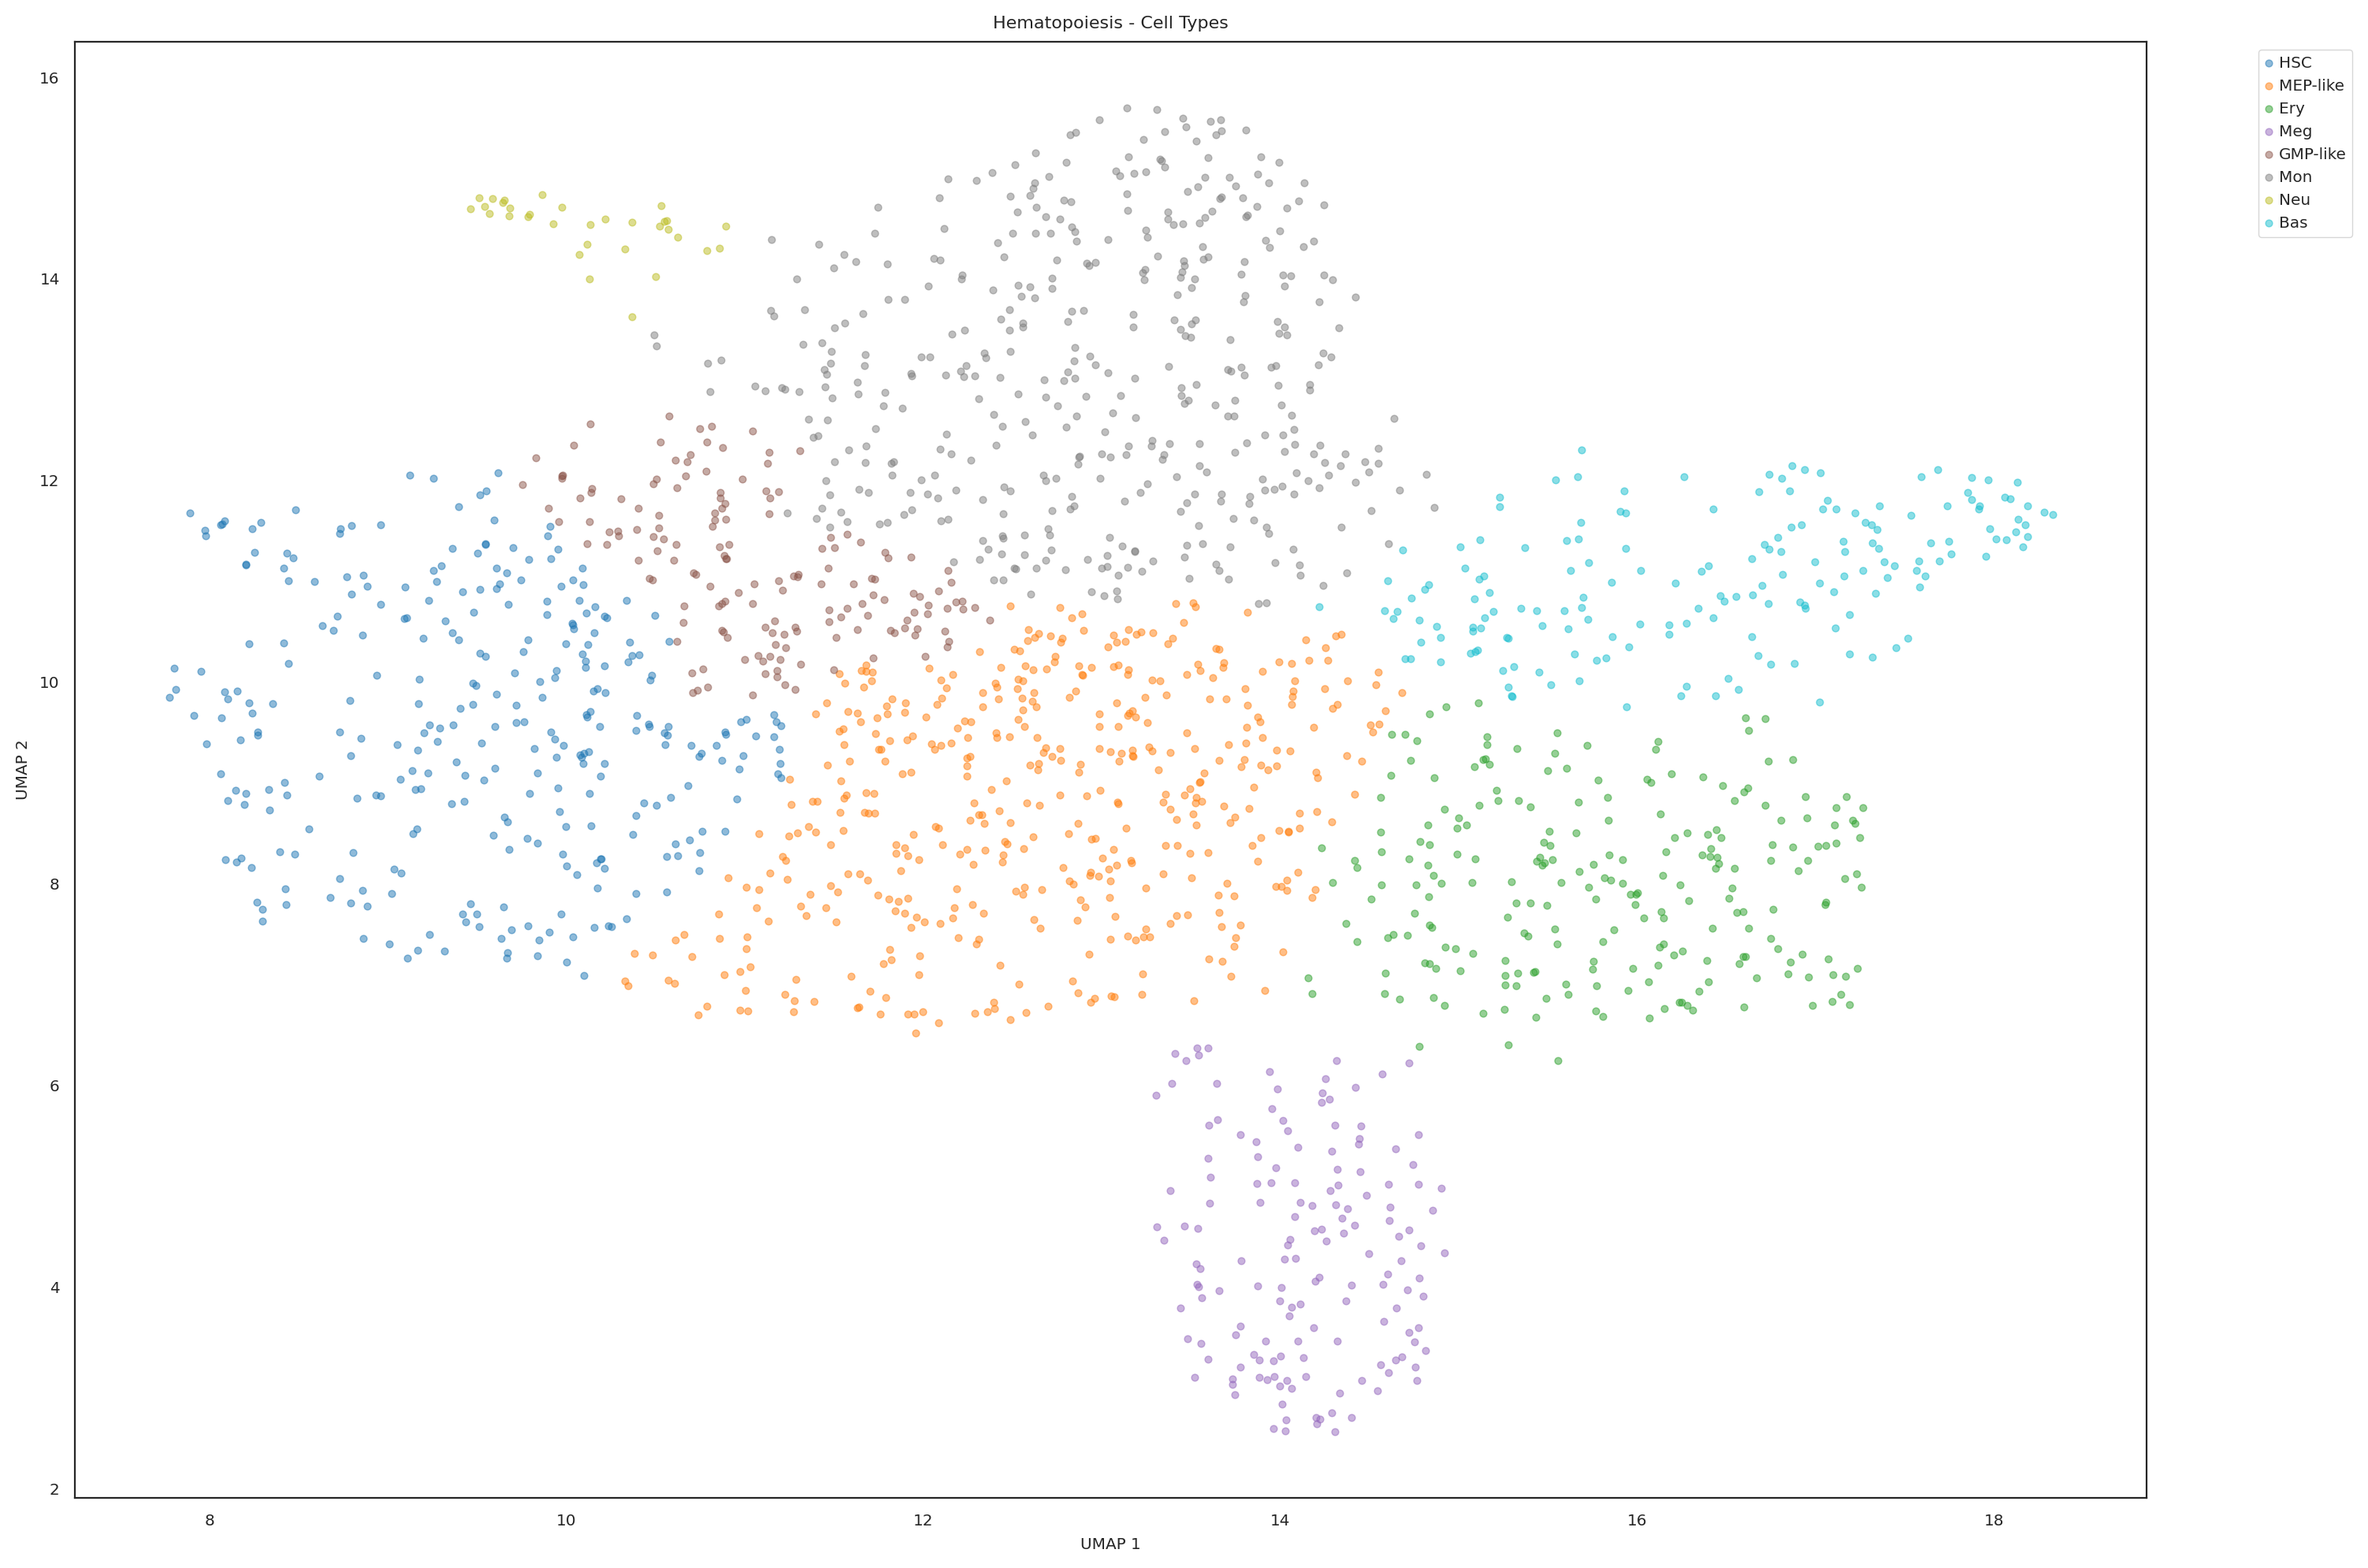

In [14]:
# 8a. UMAP with cell types
fig, ax = plt.subplots(figsize=FIGSIZE_LARGE)
for i, ct in enumerate(CELL_TYPE_ORDER):
    mask = adata.obs[CLUSTER_KEY] == ct
    ax.scatter(
        adata.obsm['X_umap'][mask, 0],
        adata.obsm['X_umap'][mask, 1],
        c=[color_dict[ct]],
        label=ct,
        s=10,
        alpha=0.5
    )
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Hematopoiesis - Cell Types')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

if show_or_save == 'show':
    plt.show()
else:
    plt.savefig('umap_celltypes.pdf', dpi=300, bbox_inches='tight')
    print("   ✓ UMAP plot saved")

In [15]:
# 8b. Energy landscapes for each cell type
for cluster in CELL_TYPE_ORDER[:4]:  # Plot first 4 as examples
    if f'grid_energy_{cluster}' in adata.uns['scHopfield']:
        fig, ax = plt.subplots(figsize=(8, 6))
        sch.pl.plot_energy_landscape(adata, cluster=cluster, basis='umap', ax=ax)
        plt.savefig(f'energy_landscape_{cluster}.pdf', dpi=300, bbox_inches='tight')
        print(f"   ✓ Energy landscape for {cluster} saved")

   ✓ Interaction matrix for HSC saved
   ✓ Interaction matrix for MEP-like saved


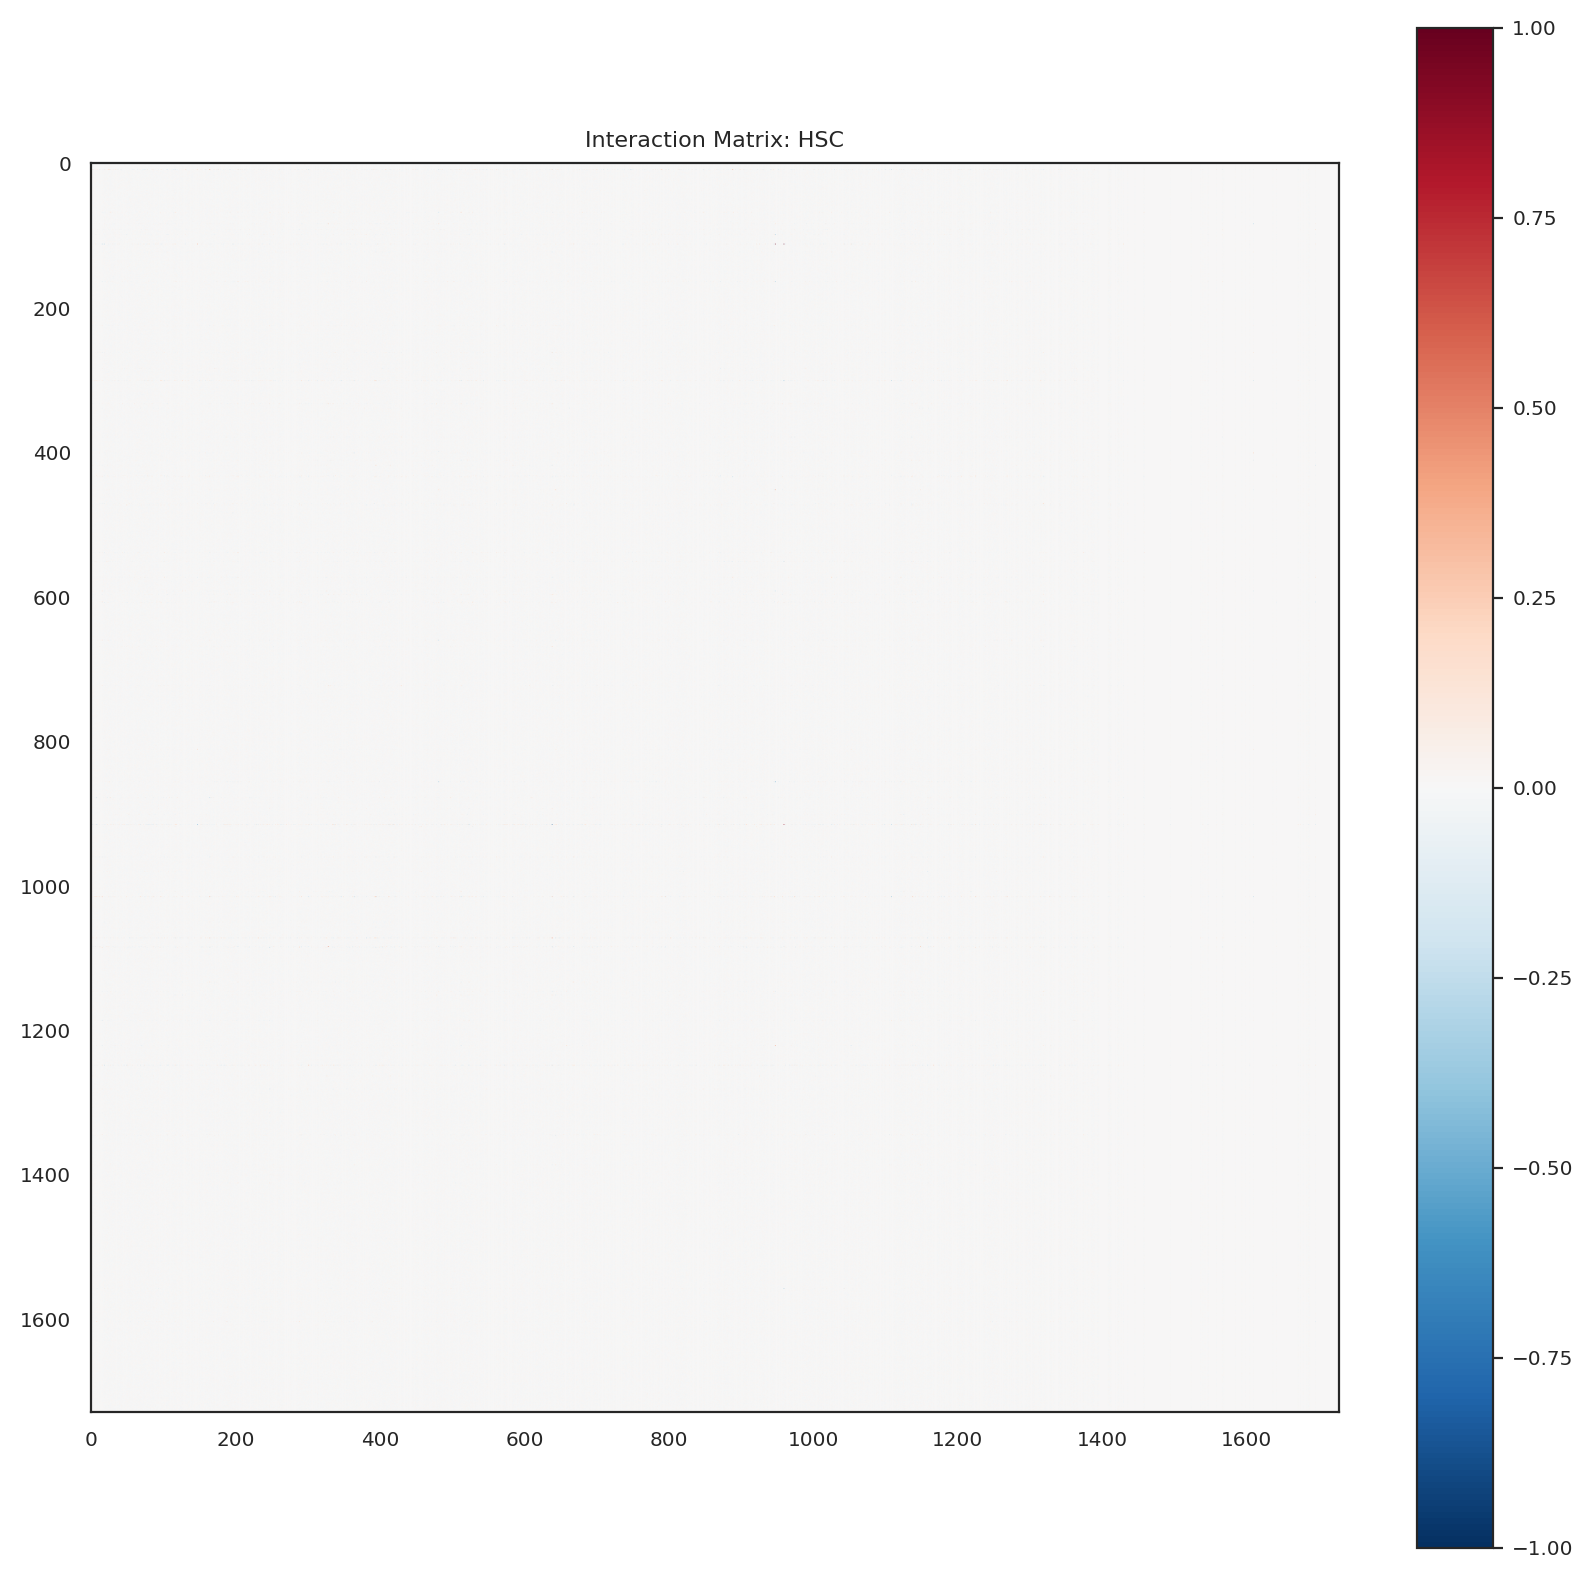

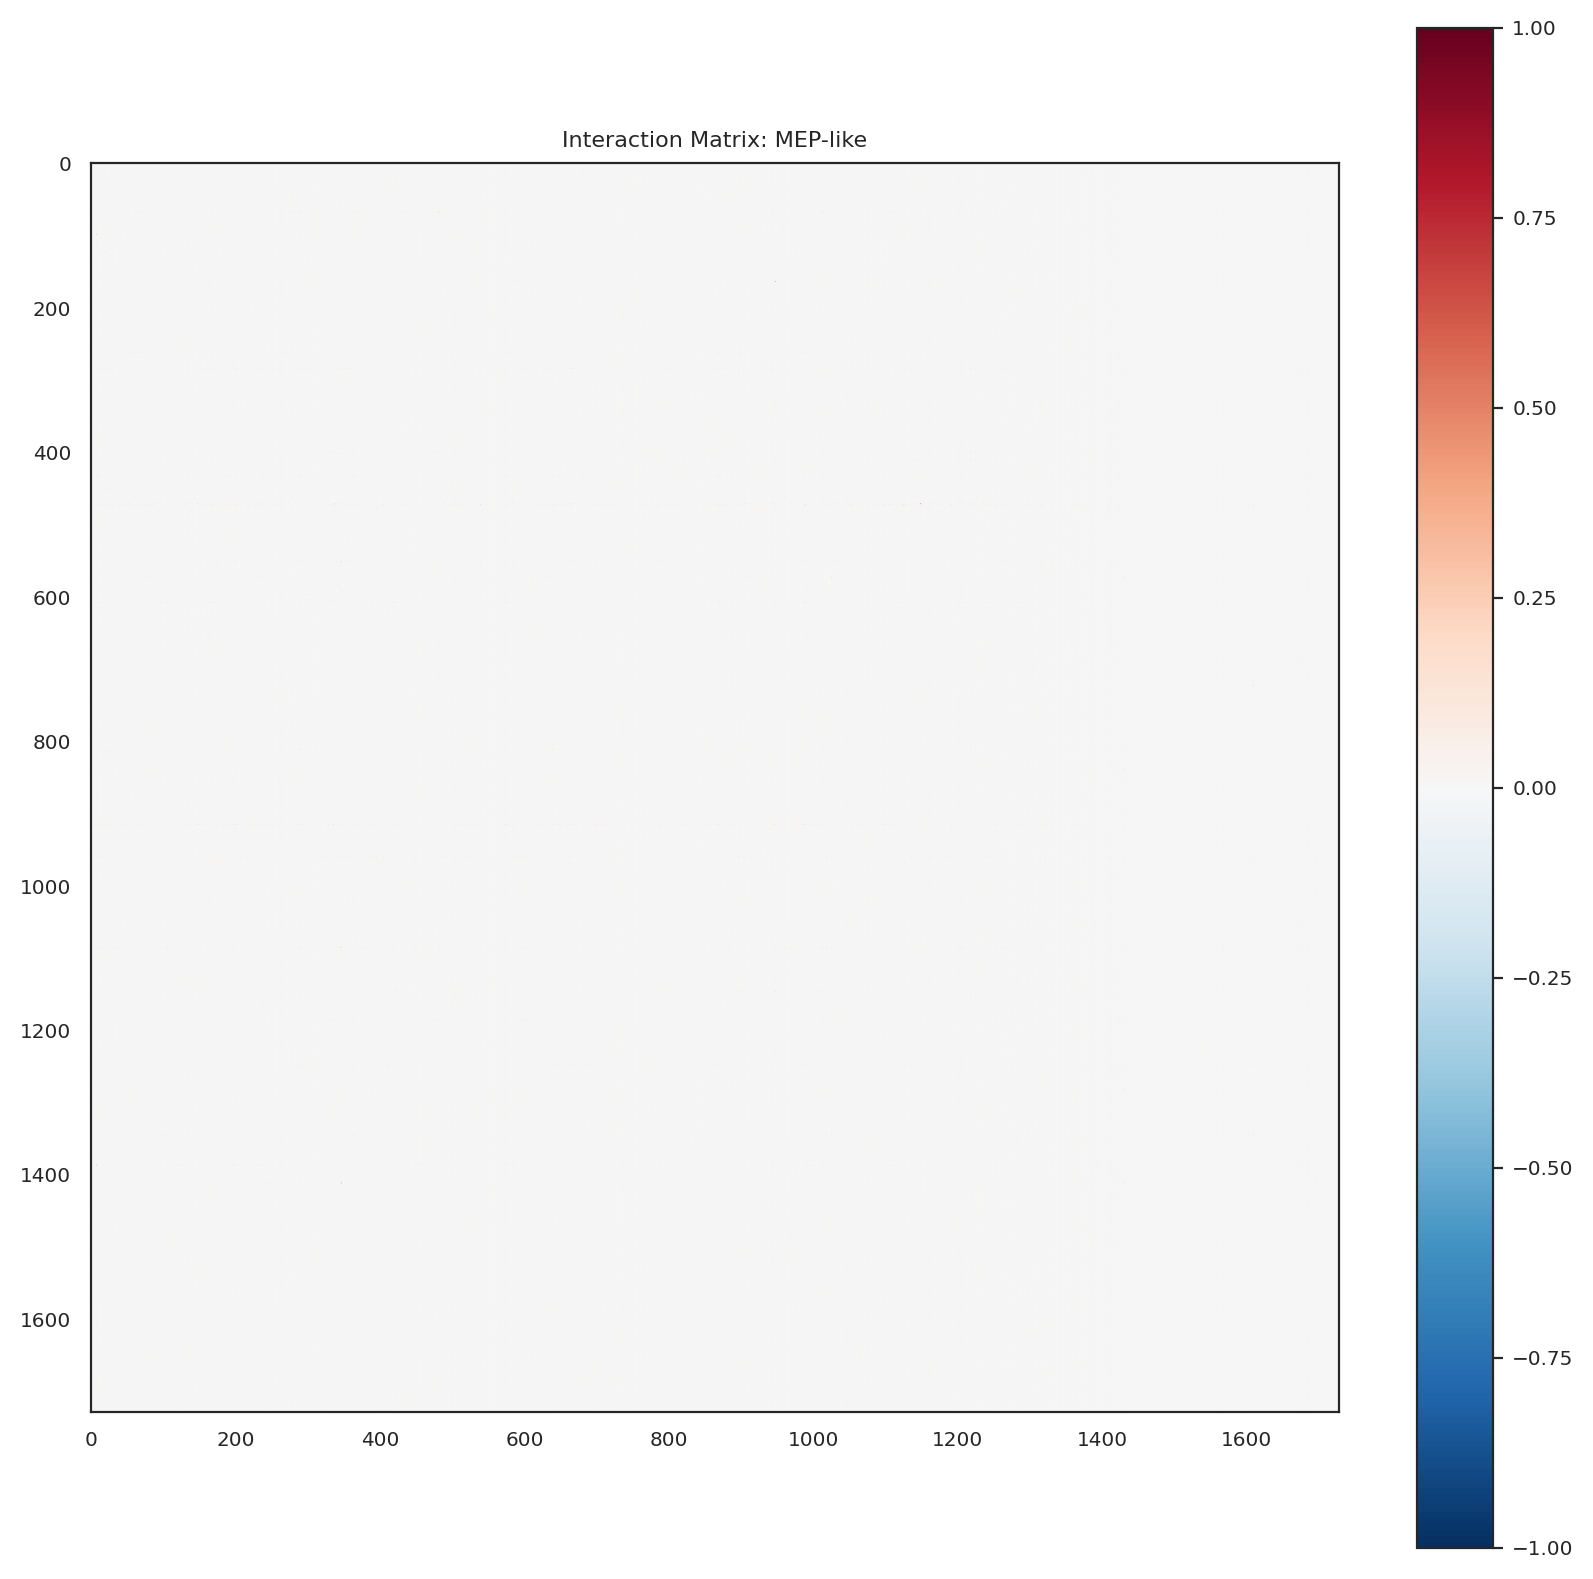

In [16]:
# 8c. Interaction matrices
for cluster in CELL_TYPE_ORDER[:2]:  # Plot first 2 as examples
    fig, ax = plt.subplots(figsize=(10, 10))
    sch.pl.plot_interaction_matrix(adata, cluster=cluster, ax=ax, vmin=-1, vmax=1)
    plt.savefig(f'interaction_matrix_{cluster}.pdf', dpi=300, bbox_inches='tight')
    print(f"   ✓ Interaction matrix for {cluster} saved")

In [ ]:

# ============================================================================

# ============================================================================




# 8c. Interaction matrices
for cluster in CELL_TYPE_ORDER[:2]:  # Plot first 2 as examples
    fig, ax = plt.subplots(figsize=(10, 10))
    sch.pl.plot_interaction_matrix(adata, cluster=cluster, ax=ax, vmin=-1, vmax=1)
    plt.savefig(f'interaction_matrix_{cluster}.pdf', dpi=300, bbox_inches='tight')
    print(f"   ✓ Interaction matrix for {cluster} saved")

# 8d. Cell type correlation dendrogram
if 'celltype_correlation' in adata.uns['scHopfield']:
    rv_matrix = adata.uns['scHopfield']['celltype_correlation']

    fig, ax = plt.subplots(figsize=(10, 4))
    Z = scp.cluster.hierarchy.linkage(squareform(1 - rv_matrix), 'complete')
    scp.cluster.hierarchy.dendrogram(Z, labels=rv_matrix.index, ax=ax)
    ax.set_title('Cell Type Correlation (RV Coefficient)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('celltype_correlation_dendrogram.pdf', dpi=300, bbox_inches='tight')
    print("   ✓ Cell type correlation dendrogram saved")

# 8e. Network similarity dendrogram
if 'network_correlations' in adata.uns['scHopfield']:
    pearson = adata.uns['scHopfield']['network_correlations']['pearson']

    fig, ax = plt.subplots(figsize=(10, 4))
    Z = scp.cluster.hierarchy.linkage(squareform(1 - pearson), 'complete')
    scp.cluster.hierarchy.dendrogram(Z, labels=pearson.index, ax=ax)
    ax.set_title('Network Similarity (Pearson Correlation)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('network_similarity_dendrogram.pdf', dpi=300, bbox_inches='tight')
    print("   ✓ Network similarity dendrogram saved")

# ============================================================================
# 9. Gene Perturbation Simulations (Optional)
# ============================================================================

RUN_SIMULATIONS = False  # Set to True to run simulations

if RUN_SIMULATIONS:
    print("\n9. Running gene perturbation simulations...")

    # Example: Simulate GATA1 knockout in HSC
    cluster = 'HSC'
    cell_idx = np.where(adata.obs[CLUSTER_KEY] == cluster)[0][0]
    t_span = np.linspace(0, 10, 100)

    # Baseline trajectory
    trajectory_baseline = sch.dyn.simulate_trajectory(
        adata,
        cluster=cluster,
        cell_idx=cell_idx,
        t_span=t_span,
        spliced_key=SPLICED_KEY,
        degradation_key=DEGRADATION_KEY
    )

    # GATA1 knockout (0.1x expression)
    trajectory_knockout = sch.dyn.simulate_perturbation(
        adata,
        cluster=cluster,
        cell_idx=cell_idx,
        gene_perturbations={'GATA1': 0.1},  # 90% knockdown
        t_span=t_span,
        spliced_key=SPLICED_KEY,
        degradation_key=DEGRADATION_KEY
    )

    # Plot trajectories for key genes
    key_genes = ['GATA1', 'GATA2', 'FLI1', 'KLF1']
    genes_used = adata.var.index[adata.var['scHopfield_used'].values]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, (gene, ax) in enumerate(zip(key_genes, axes.flat)):
        if gene in genes_used:
            gene_idx = np.where(genes_used == gene)[0][0]
            ax.plot(t_span, trajectory_baseline[:, gene_idx], label='Baseline', lw=2)
            ax.plot(t_span, trajectory_knockout[:, gene_idx], label='GATA1 KO', lw=2, ls='--')
            ax.set_xlabel('Time')
            ax.set_ylabel('Expression')
            ax.set_title(f'{gene} Expression')
            ax.legend()

    plt.tight_layout()
    plt.savefig('gata1_knockout_simulation.pdf', dpi=300, bbox_inches='tight')
    print("   ✓ GATA1 knockout simulation complete")
else:
    print("\n9. Skipping simulations (set RUN_SIMULATIONS=True to run)")

# ============================================================================
# 10. Save Results
# ============================================================================

print("\n10. Saving results...")

# Save the annotated AnnData object
adata.write_h5ad('hematopoiesis_schopfield_analysis.h5ad')
print("   ✓ AnnData object saved")

# Save energy embedding
sch.tl.save_embedding(adata, 'energy_embedding.pkl')
print("   ✓ Energy embedding saved")

# Export key results to CSV
if 'correlation_total_HSC' in adata.var.columns:
    # Top genes correlated with total energy
    corr_cols = [col for col in adata.var.columns if col.startswith('correlation_total_')]
    if corr_cols:
        correlations = adata.var[corr_cols].copy()
        correlations.to_csv('energy_gene_correlations.csv')
        print("   ✓ Energy-gene correlations exported")

# Export network statistics
if 'network_correlations' in adata.uns['scHopfield']:
    network_stats = pd.DataFrame({
        'Pearson': adata.uns['scHopfield']['network_correlations']['pearson'].values.diagonal(),
        'Jaccard': adata.uns['scHopfield']['network_correlations']['jaccard'].values.diagonal(),
        'Hamming': adata.uns['scHopfield']['network_correlations']['hamming'].values.diagonal(),
    }, index=adata.uns['scHopfield']['network_correlations']['pearson'].index)
    network_stats.to_csv('network_statistics.csv')
    print("   ✓ Network statistics exported")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)
print("\nGenerated files:")
print("  - hematopoiesis_schopfield_analysis.h5ad")
print("  - energy_embedding.pkl")
print("  - energy_gene_correlations.csv")
print("  - network_statistics.csv")
print("  - umap_celltypes.pdf")
print("  - energy_landscape_*.pdf")
print("  - interaction_matrix_*.pdf")
print("  - celltype_correlation_dendrogram.pdf")
print("  - network_similarity_dendrogram.pdf")
if RUN_SIMULATIONS:
    print("  - gata1_knockout_simulation.pdf")
if COMPUTE_JACOBIANS:
    print("  - jacobians_hematopoiesis.h5")

print("\nNext steps:")
print("  1. Examine the energy landscapes and interaction matrices")
print("  2. Investigate genes with high energy correlations")
print("  3. Compare network architectures across cell types")
print("  4. Run perturbation simulations for genes of interest")
print("\n" + "=" * 80)
